In [220]:
import torch 
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [221]:
class Data():
    def __init__(self, filename):
        data = pd.read_pickle(filename)
        d_time = data.drop(columns=['X'])
        d_pos  = data.drop(columns=['T'])
        t = d_time.iloc[:, :].values
        x =  d_pos.iloc[:, :].values

        self.t = torch.tensor(t, requires_grad=True, dtype=torch.float)
        self.x = torch.tensor(x, requires_grad=True, dtype=torch.float)

    def __len__(self):
        return len(self.t)
    
    def __getparams__(self):
        return self.t, self.x

    def __getitem__(self, idx):
        return self.t[idx], self.x[idx]


data  = Data('training-oha.pkl')  
vdata = Data('validation-oha.pkl') 
data.__len__()

20

In [222]:
class OHAModel(nn.Module):
    def __init__(self):
        super(OHAModel, self).__init__()
        self.linear = nn.Sequential(nn.Linear(1, 32), nn.Sigmoid(), nn.Linear(32, 1)) # 1 InputL, 32 HiddenL, 1 OutputL

    def forward(self, t):
        out = self.linear(t)
        return out

model = OHAModel()
print(model)

OHAModel(
  (linear): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [223]:
optimiser = torch.optim.Adam(model.parameters())

In [224]:
# Custom loss function:
# Função base:

class OHALoss(nn.Module):
    def __init__(self):
        super(OHALoss, self).__init__()

    def df(self, output : torch.Tensor, t: torch.Tensor = None, order : int=1) -> torch.Tensor:
        for _ in range(order):
            output = torch.autograd.grad(output, t, grad_outputs=torch.ones_like(t), create_graph=True, retain_graph=True)[0]
            
        return output


    def forward(self, t_physics : torch.Tensor, physics_output : torch.Tensor, output : torch.Tensor, target : torch.Tensor, coef, k):
        # DE contribution
        LossDE = self.df(physics_output, t_physics, order=2) + (coef)*self.df(physics_output, t_physics, order=1) + (k)*physics_output 

        #MSE
        LossMSE = (target - output)

        Loss = LossMSE.pow(2).mean() + LossDE.pow(2).mean()

        return Loss





In [225]:
loss_func = OHALoss()
t_physics = torch.linspace(0.01, 5, 900, requires_grad=True).view(-1,1)

# t_physics determina o domínio da função que a rede pode prever. Desse modo, caso haja necessidade de uma previsão com t > 10, a rede não será capaz de definir \
# e outro treinamento deverá ser realizado

w0 = 8.00
alpha = 2.00
coef = (alpha/t_physics).clone().detach().requires_grad_(True)
k  = pow(w0, 2)

epochs = 10000
for epoch in range(epochs):
    optimiser.zero_grad()

    physics_outputs = model(t_physics)
    output = model(data.t)

    loss = loss_func(t_physics, physics_outputs, output, data.x, coef, k)
    
    loss.backward()
    optimiser.step()
    
    if epoch % 1000 == 0:
         with torch.autograd.no_grad():
            print(f"Epoch: {epoch} - Loss: {float(loss.item()):>7f}")


Epoch: 0 - Loss: 39.808052
Epoch: 1000 - Loss: 0.123281


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


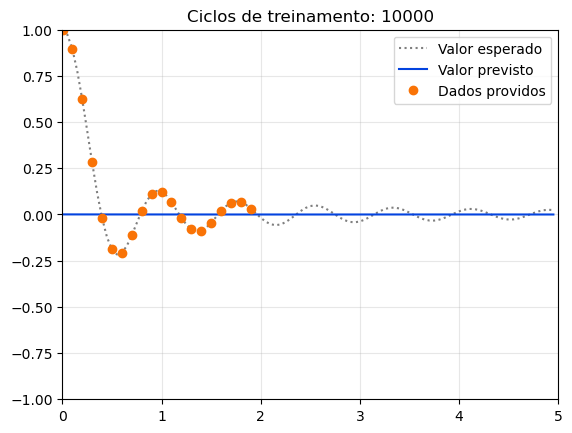

In [ ]:
model = OHAModel()
model.load_state_dict(torch.load("model.pth"))

predicted = model(vdata.t).detach().numpy()
vt = vdata.t.detach().numpy()
vx = vdata.x.detach().numpy()

t = data.t.detach().numpy()
x = data.x.detach().numpy()

plt.plot(vt, vx, color='tab:gray', linestyle=':', label='Valor esperado')
plt.plot(vt, predicted, color='xkcd:blue', linestyle='solid', label = 'Valor previsto')
plt.plot(t, x, color='xkcd:orange', marker='o', linestyle='none', label = 'Dados providos')
plt.xlim([0, 5])
plt.ylim([-1, 1])
plt.title(f'Ciclos de treinamento: {epochs}')
plt.legend(loc=1)
plt.grid(True, alpha=0.3)
plt.savefig('grafico-oha.jpg')
plt.show()

# Cálculo do erro

In [ ]:
previsto = predicted[:101]
esperado = vdata.x.detach().numpy()[:101]

erro = previsto - esperado
erro_maximo = erro[np.argmax(erro)][0]

print(f'Erro máximo encontrado na rede: {erro_maximo :.4f}')

erro_medio = np.mean(erro)

print(f'Erro médio encontrado na rede: {erro_medio :.4f}')

erro_quadratico_medio = np.power(erro, 2)
erro_quadratico_medio = np.mean(erro_quadratico_medio)

print(f'Erro quadrático médio encontrado na rede: {erro_quadratico_medio :.4f}')

Erro máximo encontrado na rede: 0.2165
Erro médio encontrado na rede: -0.0445
Erro quadrático médio encontrado na rede: 0.0439
